# Using python's cartopy package to georeference EASE-Grid 2.0 data

This notebook demonstrates the following typical tasks you might want to do with CETB EASE-Grid 2.0 data:

<ol>
    <li> Transform EASE-Grid 2.0 projected coordinates from projected meters to lat/lon </li>
    <li> Make a nice matplotlib display of some EASE-Grid 2.0 CETB brightness temperatures </li>
    <li> Overlay some vector data that you have read from a shapefile </li>
</ol>

You will need to be working in a python environment with the following packages installed.  I think the cartopy features here require it to be a python 3 environment:

<code>
    cartopy
    matplotlib
    netCDF4
    shapely
</code>


In [1]:
%matplotlib notebook
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Transformations from projected meters to lat/lon

In cartopy documentation, I do not see support for the EASE-Grid 2.0 cylindrical equal area projection, so I think this will only work for Northern and Southern EASE-Grid 2.0 projections.

I have submitted a feature request to cartopy to add the cylindrical projection (7/27/2018).

# Define cartopy coordinate reference system (ccrs) objects

Here is cartopy documentation for supported projections:

https://scitools.org.uk/cartopy/docs/latest/crs/projections.html

So we can set up objects for EASE-Grid 2.0 North and for lat/lon, which cartopy calls "geodetic":

In [2]:
geod = ccrs.Geodetic()
e2n = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0)

# Transforms to-from projected meters and lat/lon

Notes:

The src_crs is the crs that describes the input point.

<table>
    <TR>
        <TH> Location </TH>
        <TH> EASE2_N (m)</TH>
        <TH> Geodetic (degrees)</TH>
    </TR>
    <tr>
        <td> UL corner </td>
        <td> [-9000000., 9000000.] </td>
        <td> [-135., -84.636050] </td>
    </tr>
    <tr>
        <td> Pole </td>
        <td> [0., 0.] </td>
        <td> [0, 90.] </td>
    </tr>
    <tr>
        <td> LR corner </td>
        <td> [9000000., -9000000.] </td>
        <td> [45., -84.636050] </td>
    </tr>
</table>

In [3]:
UL_corner_m = [-9000000., 9000000.] # [x, y] in meters, UL corner of EASE2_N projection
lon, lat = geod.transform_point(
    x = UL_corner_m[0],
    y = UL_corner_m[1],
    src_crs = e2n)
print(lon, lat)

-135.0 -84.6340496694687


In [4]:
pole_m = [0., 0.] # [x, y] in meters, North Pole of EASE2_N projection
lon, lat = geod.transform_point(
    x = pole_m[0],
    y = pole_m[1],
    src_crs = e2n)
print(lon, lat)

0.0 90.0


In [5]:
LR_corner_m = [9000000., -9000000.] # [x, y] in meters, LR corner of EASE2_N projection
lon, lat = geod.transform_point(
    x = LR_corner_m[0],
    y = LR_corner_m[1],
    src_crs = e2n)
print(lon, lat)

45.0 -84.6340496694687


# And you can transform from lat,lon to x,y:

In [6]:
UR_corner_geod = [135., -84.634050]
x, y = e2n.transform_point(
    x = UR_corner_geod[0],
    y = UR_corner_geod[1],
    src_crs = geod)
print(x, y)


9000000.001226343 9000000.001226341


# cartopy can be used with matplotlib for nice georeferenced plots/displays

Use the projection keyword to the plt.axes command to set the projection to the ccrs you want to display.  This will return a GeoAxesSubplot object that "knows" about map projections.

You need to control the extent with the set_extent keyword, and you can use built-in routines to get gridlines and coastlines


<IPython.core.display.Javascript object>


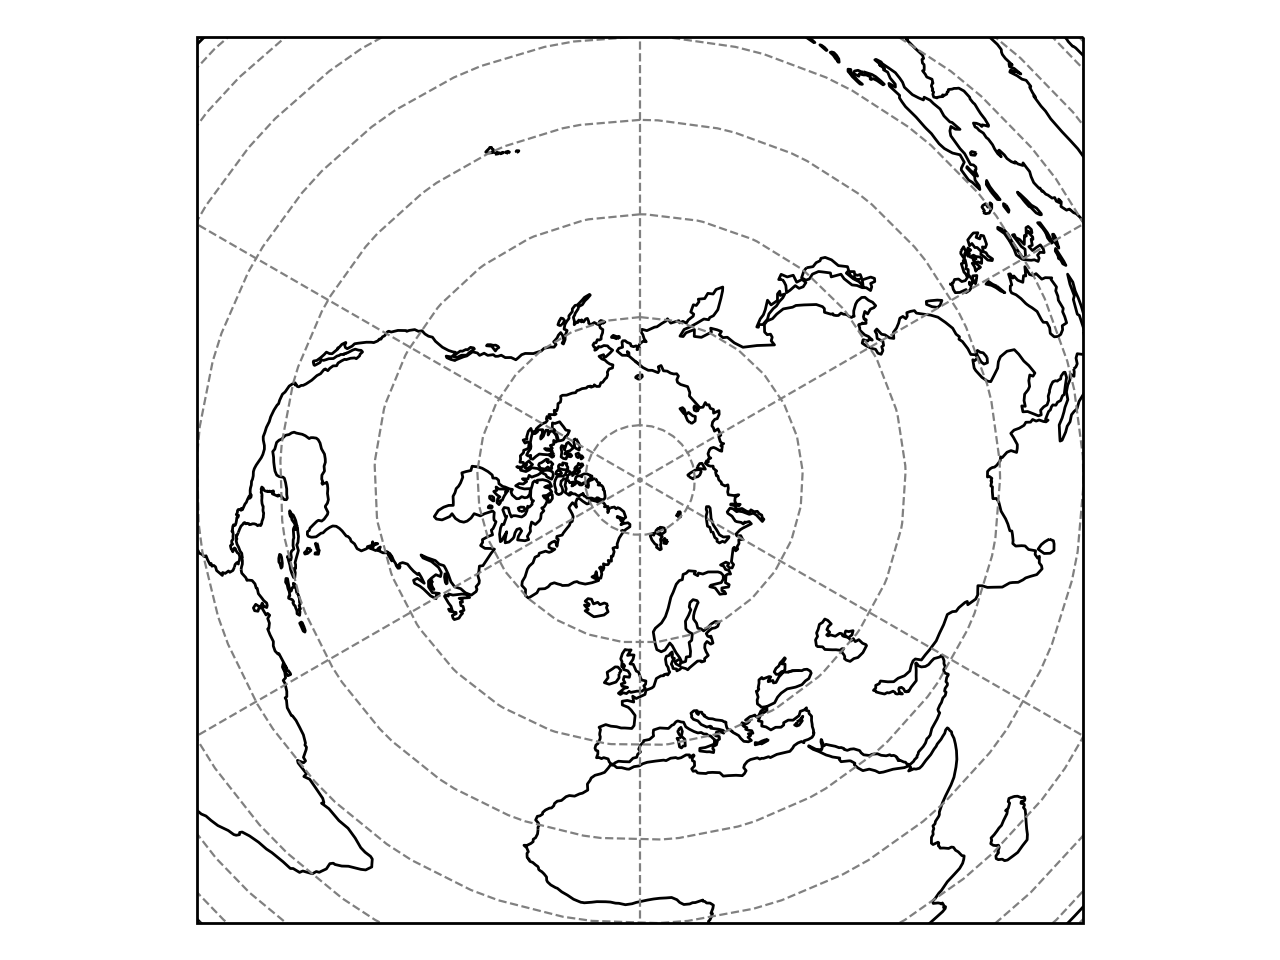

In [7]:
plt.figure()

e2n_full_extent = [-9000000., 9000000., -9000000., 9000000.] # Full extent, in projected coords: [ULx, LRx, ULy, LRy]
ax = plt.axes(projection=e2n)
ax.set_extent(e2n_full_extent, crs=e2n) # you have to tell it what projection to use to interpret the extent
ax.gridlines(color='gray', linestyle='--')
ax.coastlines()

plt.tight_layout()
plt.show()


# You can limit the display extent to a smaller area

Like the lower right quadrant of the projection extent

<IPython.core.display.Javascript object>


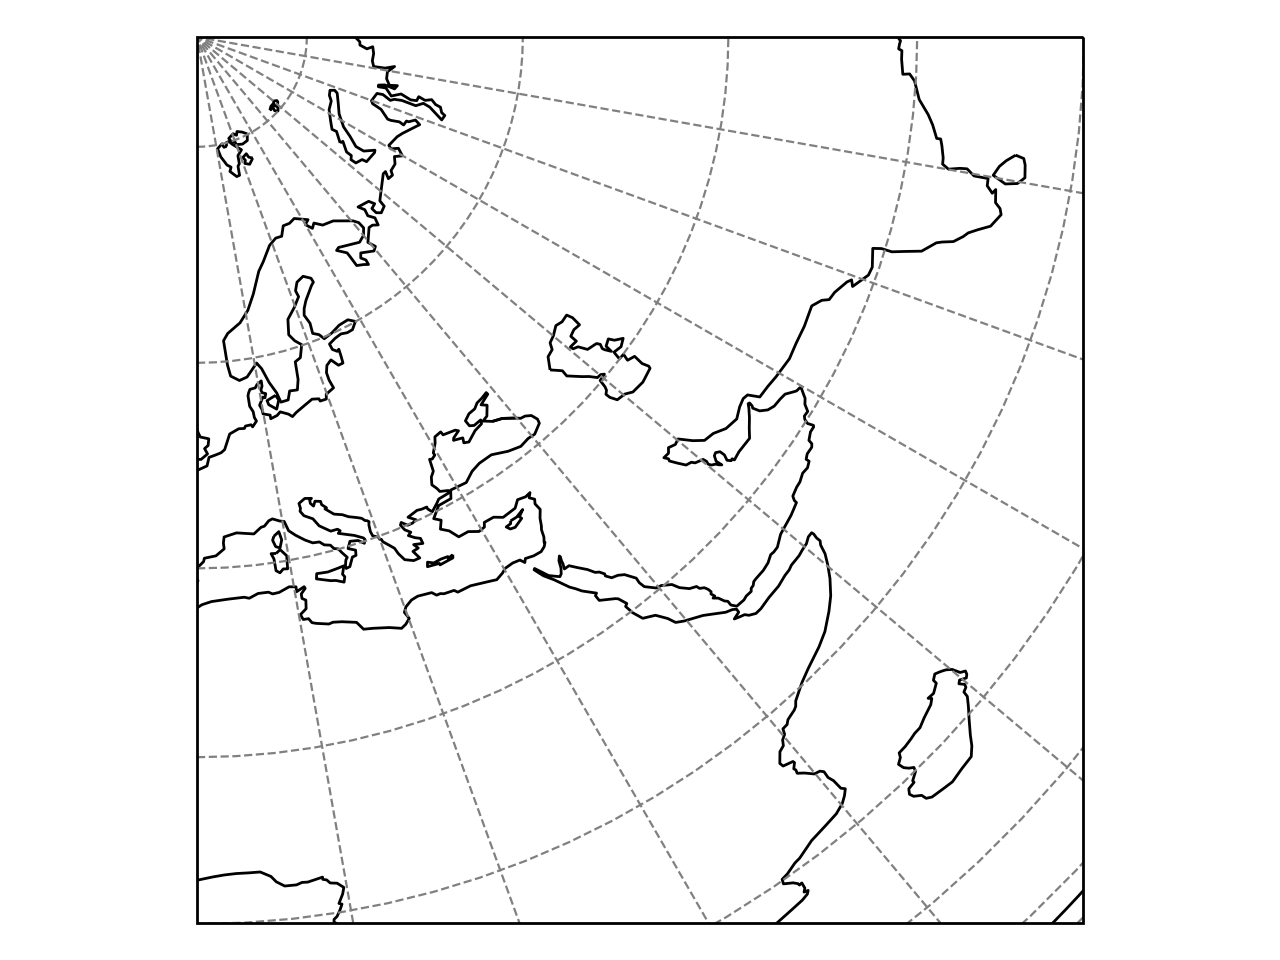

In [8]:
plt.figure()

# Lower right quadrant of hemisphere:
extent = [0., 9000000., -9000000., 0.] # Extent, in projected coords: [x_min, x_max, y_min, y_max]
ax = plt.axes(projection=e2n)
ax.set_extent(extent, crs=e2n) # you have to tell it what projection to use to interpret the extent
ax.gridlines(color='gray', linestyle='--')
ax.coastlines()

plt.tight_layout()
plt.show()


# Or the Western US, for example

I can the mouse to hover over the full hemisphere and get lat/lon of subset UL and LR, and then transform them to projected coords, then use that to limit the display extent:


In [9]:
westUS_UL_geod = [-114.57, 12.05]
westUS_UL_m = e2n.transform_point(
    x = westUS_UL_geod[0],
    y = westUS_UL_geod[1],
    src_crs = geod)
print(westUS_UL_m)

(-7292918.432053986, 3334340.871500917)


In [10]:
westUS_LR_geod = [-100.34, 50.53]
westUS_LR_m = e2n.transform_point(
    x = westUS_LR_geod[0],
    y = westUS_LR_geod[1],
    src_crs = geod)
print(westUS_LR_m)

(-4245692.389989166, 774635.4073810637)


<IPython.core.display.Javascript object>


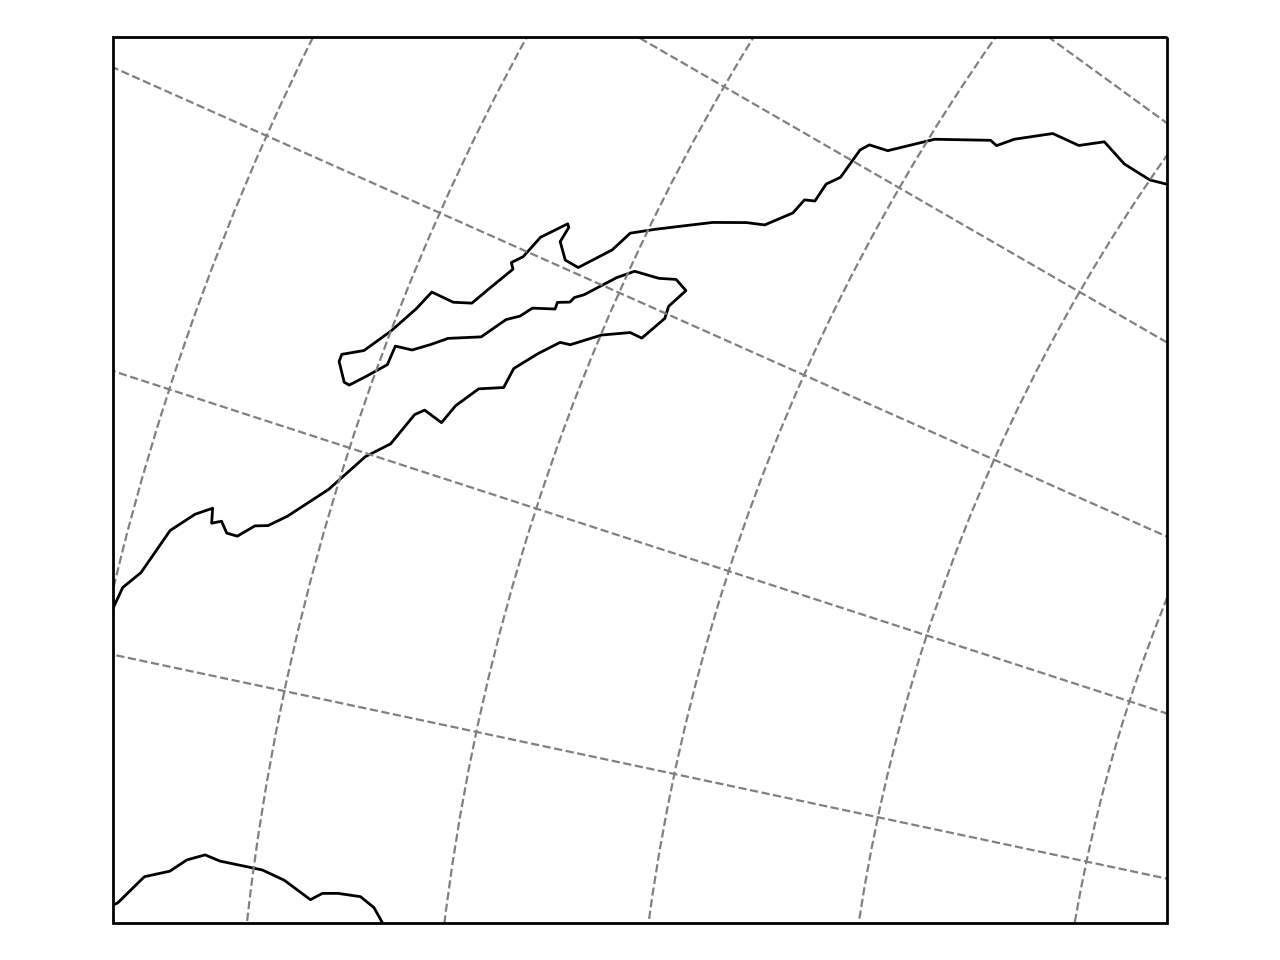

In [11]:
plt.figure()

# Western US:
# Full extent, in projected coords: [x_min, x_max, y_min, y_max]
extent = [westUS_UL_m[0], westUS_LR_m[0], westUS_UL_m[1], westUS_LR_m[1]] 
ax = plt.axes(projection=e2n)
ax.set_extent(extent, crs=e2n) # you have to tell it what projection to use to interpret the extent
ax.gridlines(color='gray', linestyle='--')
ax.coastlines()

plt.tight_layout()
plt.show()

# Now read in a CETB file and add the TB data to a full display

Note that the matplotlib zoom and pan functions work here



In [12]:
from netCDF4 import Dataset
import numpy as np

file = "/Users/brodzik/ExploringCETB/data/NSIDC-0630-EASE2_N3.125km-AQUA_AMSRE-2004164-36H-M-SIR-RSS-v1.3.nc"
f = Dataset(file, 'r', 'netCDF4')

In [13]:
tb = np.squeeze(f.variables['TB'][:])
tb.shape

(5760, 5760)

In [14]:
f.close()

<IPython.core.display.Javascript object>


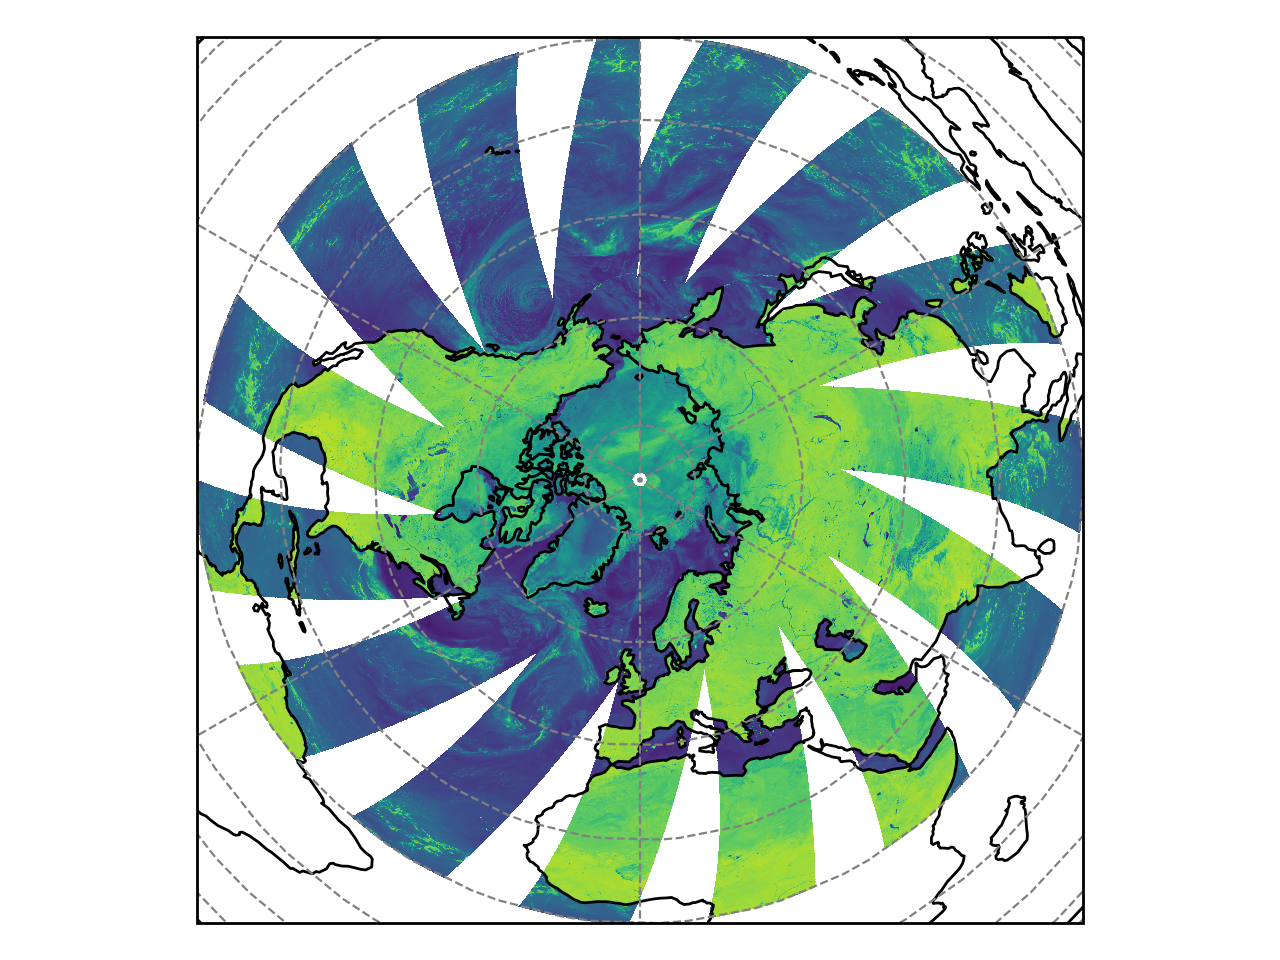

In [15]:
plt.figure()

ax = plt.axes(projection=e2n)
ax.set_extent(e2n_full_extent, crs=e2n) # you have to tell it what projection to use to interpret the extent

ax.imshow(tb, extent=e2n_full_extent, transform=e2n, origin='upper')

ax.gridlines(color='gray', linestyle='--')
ax.coastlines()

plt.tight_layout()
plt.show()

# Or subset the data to your region of interest, and limit the extent to just that region

This takes a little more work, because you have to know what the projected corners of your subset are in col/row coordinates.

<IPython.core.display.Javascript object>


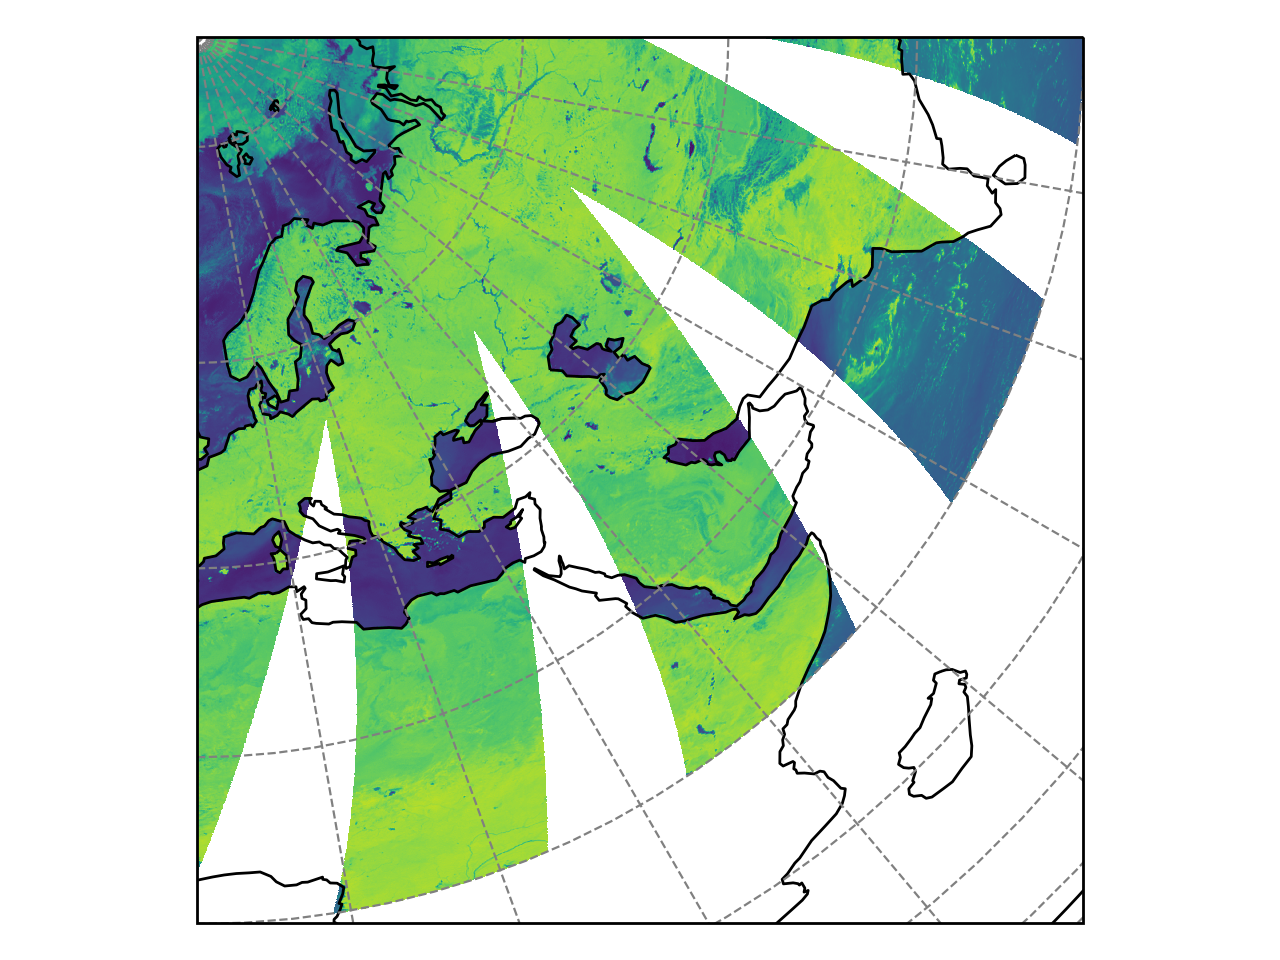

In [16]:
lrquad_tb = tb[2880:, 2880:]

extent = [0., 9000000., -9000000., 0.] 

plt.figure()

ax = plt.axes(projection=e2n)
ax.set_extent(extent, crs=e2n)

ax.imshow(lrquad_tb, extent=extent, transform=e2n, origin='upper')

ax.gridlines(color='gray', linestyle='--')
ax.coastlines()

plt.tight_layout()
plt.show()

# Now you can use cartopy's io shapefile interface to read a Hunza basin shapefile--or any other shapefile

Apparently there are other ways to read shapefiles, this is just one way...

In [17]:
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom

bfile = '/Users/brodzik/ExploringCETB/data/IN_Hunza_at_DainyorBridge.shp'

In [18]:
reader = shpreader.Reader(bfile)
record = next(reader.records())

In [19]:
record

<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x11cc4d358>, {'GRDC_NO': 2335100, 'WMO_REG': 2, 'SUB_REG': 35, 'MIX_REG': 235, 'NAT_ID': '1001', 'RIVER': 'HUNZA RIVER', 'STATION': 'DANYOUR BRIDGE', 'COUNTRY_CO': 'PK', 'LAT_ORG': 35.92, 'LONG_ORG': 74.38, 'LAT_NEW': 35.9271, 'LONG_NEW': 74.3729, 'DIST_KM': 1.0, 'AREA': 12950.0, 'AREA_HYS': 13746.4, 'AREA_DIFF': 6.1, 'ALTITUDE': -999.0, 'ELEV_HYS': 1446, 'DS_STAT_NO': 2335200, 'W_LEVEL': 0, 'D_START': 1978, 'D_END': 1982, 'D_YRS': 5, 'D_MISS': 20, 'M_START': 1978, 'M_END': 1982, 'M_YRS': 5, 'M_MISS': 20, 'T_START': 1978, 'T_END': 1982, 'T_YRS': 5, 'LTA_DISCHA': 381.128, 'DISC_HYS': 55.74, 'DISC_DIFF': -85.4, 'R_VOLUME_Y': 12, 'R_HEIGHT_Y': 928, 'PROC_TYRS': 80, 'PROC_TMON': 100, 'F_IMPORT': '16.1.1992', 'F_IM_YR': 1992, 'L_IMPORT': '10.5.1996', 'L_IM_YR': 1996, 'PROVIDER_I': -999, 'ACSYS': 0, 'FLUX2OCEAN': 0, 'GEMS': 0, 'GCOS_GTN_H': 0, 'STATISTICS': 0, 'CODE': 2, 'QUALITY': 'Medium', 'TYPE': 'Automatic', 'COMMENT': 'Area

In [20]:
record.attributes

{'GRDC_NO': 2335100,
 'WMO_REG': 2,
 'SUB_REG': 35,
 'MIX_REG': 235,
 'NAT_ID': '1001',
 'RIVER': 'HUNZA RIVER',
 'STATION': 'DANYOUR BRIDGE',
 'COUNTRY_CO': 'PK',
 'LAT_ORG': 35.92,
 'LONG_ORG': 74.38,
 'LAT_NEW': 35.9271,
 'LONG_NEW': 74.3729,
 'DIST_KM': 1.0,
 'AREA': 12950.0,
 'AREA_HYS': 13746.4,
 'AREA_DIFF': 6.1,
 'ALTITUDE': -999.0,
 'ELEV_HYS': 1446,
 'DS_STAT_NO': 2335200,
 'W_LEVEL': 0,
 'D_START': 1978,
 'D_END': 1982,
 'D_YRS': 5,
 'D_MISS': 20,
 'M_START': 1978,
 'M_END': 1982,
 'M_YRS': 5,
 'M_MISS': 20,
 'T_START': 1978,
 'T_END': 1982,
 'T_YRS': 5,
 'LTA_DISCHA': 381.128,
 'DISC_HYS': 55.74,
 'DISC_DIFF': -85.4,
 'R_VOLUME_Y': 12,
 'R_HEIGHT_Y': 928,
 'PROC_TYRS': 80,
 'PROC_TMON': 100,
 'F_IMPORT': '16.1.1992',
 'F_IM_YR': 1992,
 'L_IMPORT': '10.5.1996',
 'L_IM_YR': 1996,
 'PROVIDER_I': -999,
 'ACSYS': 0,
 'FLUX2OCEAN': 0,
 'GEMS': 0,
 'GCOS_GTN_H': 0,
 'STATISTICS': 0,
 'CODE': 2,
 'QUALITY': 'Medium',
 'TYPE': 'Automatic',
 'COMMENT': 'Area difference 5-10% and dist

In [21]:
record.bounds

(74.02507731119763, 35.92307128906174, 75.77779744466116, 37.09783732096277)

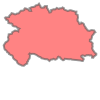

In [22]:
record.geometry

# Now, since the Hunza crs is just geodetc and we already have a ccrs for this, you can just add the shapefile to the display

## Note that you can zoom/pan with the mouse controls, and they will give you mouse position coordinates (projected and geodetic) and the value of the pixel you are looking at

<IPython.core.display.Javascript object>


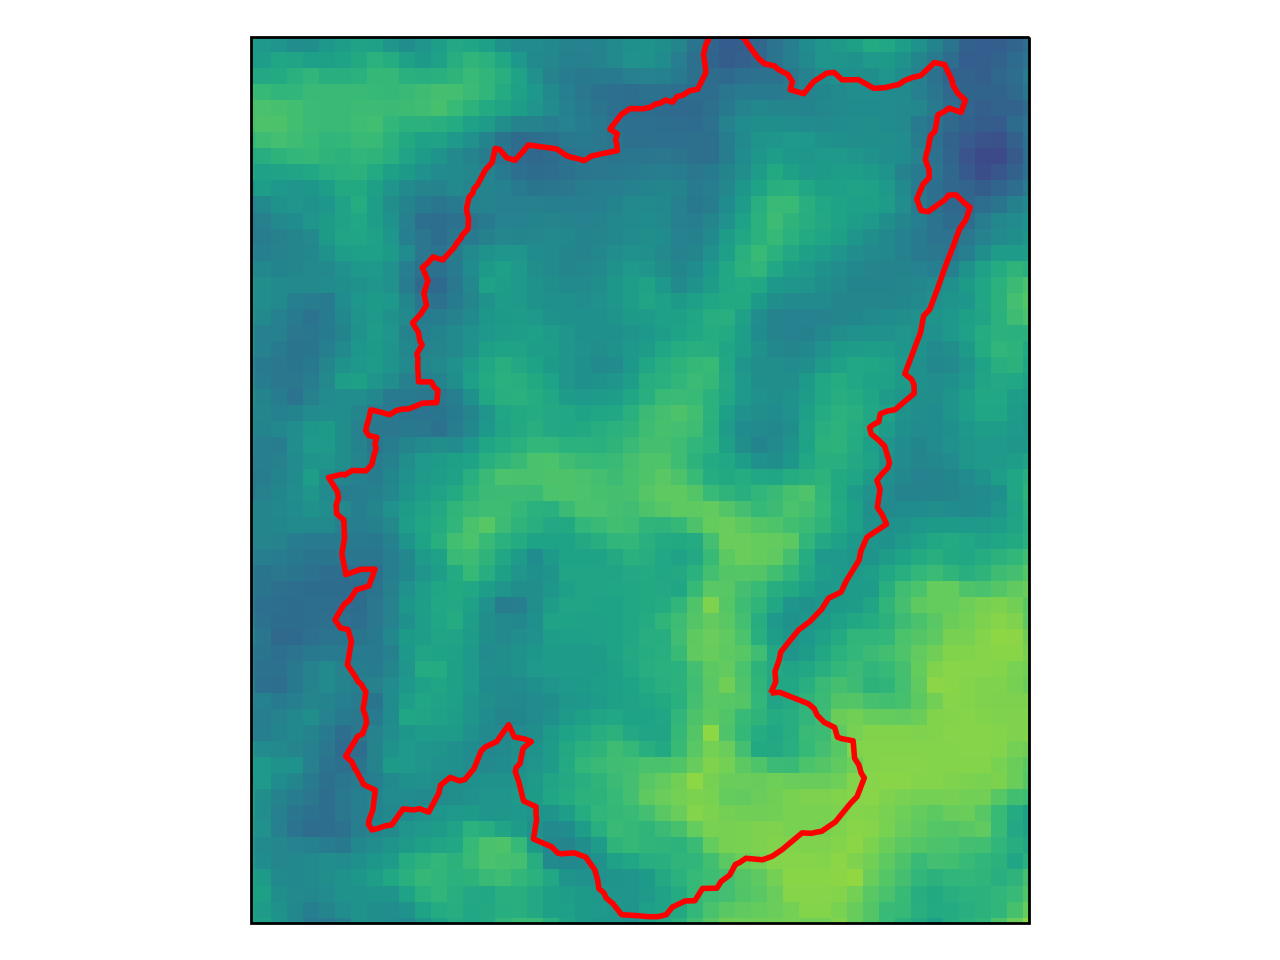

In [23]:
plt.figure()

ax = plt.axes(projection=e2n)
ax.set_extent(extent, crs=e2n)

ax.imshow(lrquad_tb, extent=extent, transform=e2n, origin='upper')

ax.gridlines(color='gray', linestyle='--')
ax.coastlines()

ax.add_geometries(
    [record.geometry], geod,
   edgecolors='red', facecolor='none', lw=2)

plt.tight_layout()
plt.show()


# Lastly, if your shapefile geometry is not in geodetic, I think you can also reproject shapefile geometry objects directly into e2n and then pass that into the axes

I think that you don't need to know what the projection of the input shapefile is, it will get it from the record.geometry object (not certain about this).

Doing it this way, you tell the ax.add_geometries method that the data are already in e2n

<IPython.core.display.Javascript object>


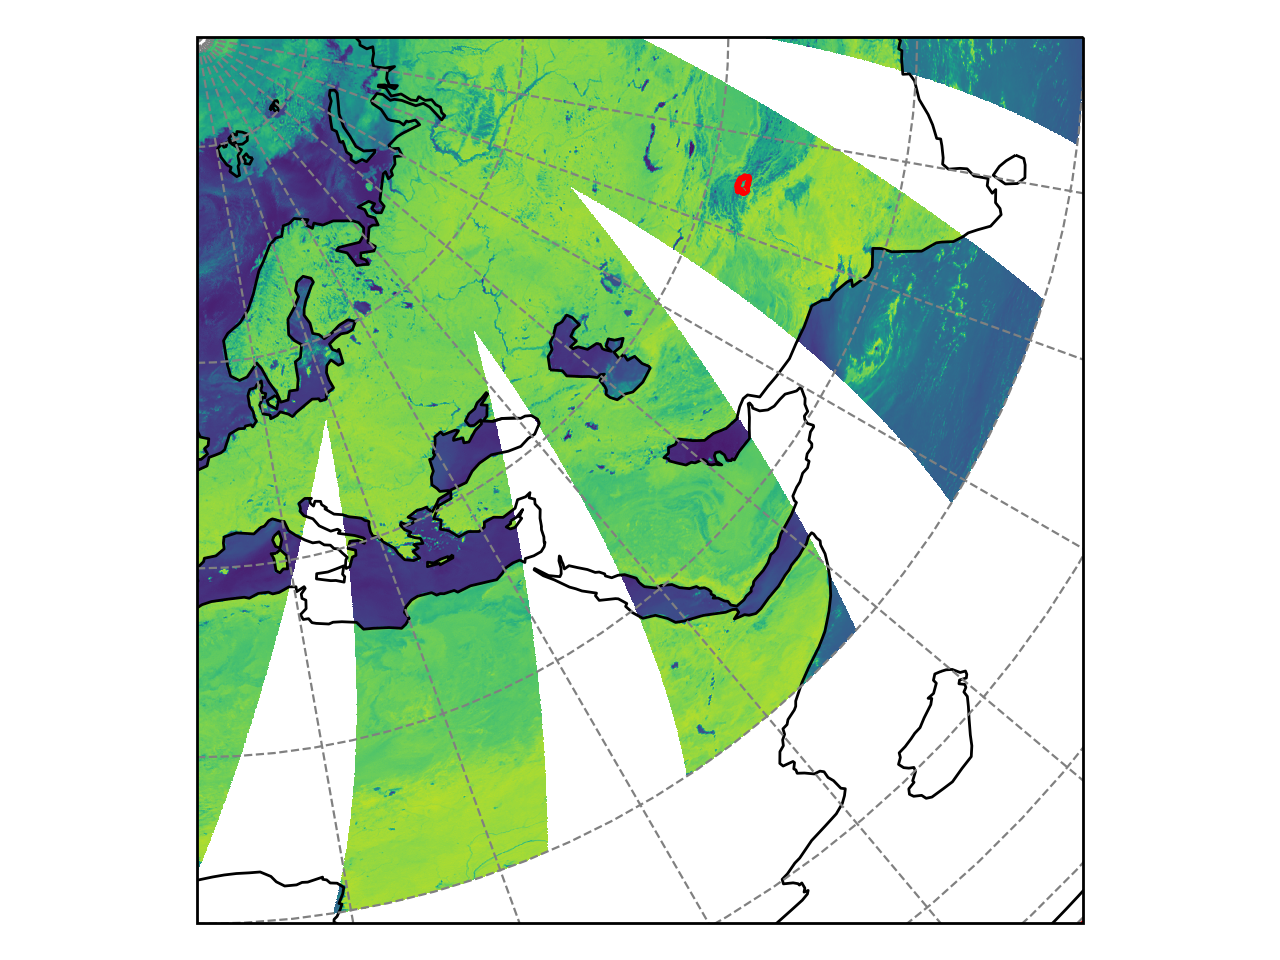

In [24]:
basin_e2n = e2n.project_geometry(record.geometry)

plt.figure()

ax = plt.axes(projection=e2n)
ax.set_extent(extent, crs=e2n)

ax.imshow(lrquad_tb, extent=extent, transform=e2n, origin='upper')

ax.gridlines(color='gray', linestyle='--')
ax.coastlines()

ax.add_geometries(
    [basin_e2n], e2n,
    edgecolors='red', facecolor='none', lw=2)

plt.tight_layout()
plt.show()

# I'm pretty sure there's a lot of rich functionality here, I just wanted to summarize the basics that I have figured out so far

For example, if you zoom to a box around the Hunza sub basin and call 

ax.get_extent()

it will give the zoomed extent coordinates, in projected meters, which could be really handy.  This would eliminate the steps in the example above, where I found the Western US subset by reading the lat/lon off the plot and converted them manually.

In [25]:
help(ax)

Help on GeoAxesSubplot in module cartopy.mpl.geoaxes object:

class GeoAxesSubplot(matplotlib.axes._subplots.SubplotBase, GeoAxes)
 |  Base class for subplots, which are :class:`Axes` instances with
 |  additional methods to facilitate generating and manipulating a set
 |  of :class:`Axes` within a figure.
 |  
 |  Method resolution order:
 |      GeoAxesSubplot
 |      matplotlib.axes._subplots.SubplotBase
 |      GeoAxes
 |      matplotlib.axes._axes.Axes
 |      matplotlib.axes._base._AxesBase
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods inherited from matplotlib.axes._subplots.SubplotBase:
 |  
 |  __init__(self, fig, *args, **kwargs)
 |      *fig* is a :class:`matplotlib.figure.Figure` instance.
 |      
 |      *args* is the tuple (*numRows*, *numCols*, *plotNum*), where
 |      the array of subplots in the figure has dimensions *numRows*,
 |      *numCols*, and where *plotNum* is the number of the subplot
 |      being created.  *plotNum* starts at 1